# Week 7 Exercises: Dimensionality Reduction and Feature Selection
# Rahul Rajeev

## Part 1: PCA and Variance Threshold in a Linear Regression

In [228]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import tree

In [229]:
# import data frame and check that it loaded properly
prices_df = pd.read_csv('housingprices_train.csv')
prices_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [230]:
prices_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [231]:
# 2. Drop the "Id" column and any features that are missing more than 40% of their values.
drop = ['Id']
for col in prices_df.columns:
    if prices_df[col].isnull().sum() / len(prices_df[col]) > 0.4:
        drop.append(col)
    else:
        continue

drop

['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [232]:
# dropping the columns
prices_df2 = prices_df.drop(drop, axis=1)

In [233]:
# 3. replace the NaN values in the numerical columns with the median
for col in prices_df2.select_dtypes(exclude = 'object').columns:
    #print(col)
    if prices_df2[col].isnull().sum() > 0:
        prices_df2[col].fillna(prices_df2[col].median(), inplace=True)

In [234]:
# 4. replace the NaN values in the categorical columns with the mode
for col in prices_df2.select_dtypes(exclude=['int64','float64']).columns:
    if prices_df2[col].isnull().sum() > 0:
        prices_df2[col].fillna(prices_df2[col].mode()[0], inplace=True)

In [235]:
# double checking for any more missing values
max(prices_df2.isnull().sum())

0

In [236]:
# 5. Convert the categorical columns to dummy variables.
prices_df3 = pd.get_dummies(prices_df2, columns = [col for col in prices_df2.select_dtypes(exclude=['int64','float64'])])

In [237]:
#6. Split the data into a training and test set, where the SalePrice column is the target.
X = prices_df3.drop(['SalePrice'], axis=1)
Y = prices_df3['SalePrice']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

In [238]:
# 7. Run a linear regression and report the R2-value and RMSE on the test set.
linreg = LinearRegression()
linmodel = linreg.fit(Xtrain,Ytrain)

In [239]:
# R2
predictions1 = linmodel.predict(Xtest)
print('R2:', r2_score(Ytest, predictions1), '| RMSE:', mean_squared_error(Ytest, predictions1, squared = False), 
      '| MAE:', mean_absolute_error(Ytest, predictions1))

R2: 0.8569712258135866 | RMSE: 27514.55135267843 | MAE: 17523.713224464944


**Thoughts:** The R2 looks quite good, but the RMSE and the MAE could use some work.

In [240]:
# 8. Fit and transform the training features with a PCA so that 90% of the variance is retained
pca = PCA(n_components = 0.90, whiten=True)

# standardize
sc = StandardScaler()
standard_features = sc.fit_transform(Xtrain)
standard_test_features = sc.transform(Xtest)

# conduct PCA
features_pca = pca.fit_transform(standard_features)

In [241]:
# 9. How many features are in the PCA-transformed matrix?
print('Original:',Xtrain.shape[1], 'Reduced', features_pca.shape[1])

Original: 270 Reduced 135


In [242]:
# 10. Transform but DO NOT fit the test features with the same PCA.
test_features_pca = pca.transform(standard_test_features)

In [243]:
# 11. Repeat step 7 with your PCA transformed data.
linmodel2 = linreg.fit(features_pca,Ytrain)

In [244]:
predictions2 = linmodel2.predict(test_features_pca)
print('R2:', r2_score(Ytest, predictions2), '| RMSE:', mean_squared_error(Ytest, predictions2, squared = False), 
      '| MAE:', mean_absolute_error(Ytest, predictions2))

R2: 0.874856059562934 | RMSE: 25736.864743805876 | MAE: 18738.89534295538


**Thoughts:** The R2 has gone down slightly, and both RMSE and MAE have increased.

In [245]:
# 12. Take your original training features (from step 6) and apply a min-max scaler to them.
minmaxsc = MinMaxScaler()

# scaling
minmaxsc_features = minmaxsc.fit_transform(Xtrain)
test_minmaxsc_features = minmaxsc.transform(Xtest)

In [246]:
# 13. Find the min-max scaled features in your training set that have a variance above 0.1
low_thresholder = VarianceThreshold(threshold = 0.2)
variances_array = low_thresholder.fit(minmaxsc_features).variances_

In [247]:
# creating arrays of features before and after the variance sort
above_variance = [i for i,v in enumerate(variances_array) if v > 0.1]
features = np.array(prices_df3.columns)
features_above = features[above_variance]
print('Total features:', len(features), '| Above 0.1:', len(features_above))

Total features: 271 | Above 0.1: 50


In [248]:
# the highest variance is 0.2499
high_variance = max(variances_array)
high_variance

0.24997361137173957

In [249]:
# Let's fit_transform the training data, and transform the test data for features with high variance (above 0.2)
high_thresholder = VarianceThreshold(threshold = 0.20)
features_high_variance = high_thresholder.fit_transform(minmaxsc_features)

In [250]:
# 14. Transform but DO NOT fit the test features with the same steps applied in steps 11 and 12.
test_features_high_variance = high_thresholder.transform(test_minmaxsc_features)

In [251]:
# 15. Repeating linear regression with new data
linmodel3 = linreg.fit(features_high_variance,Ytrain)

In [252]:
predictions3 = linmodel3.predict(test_features_high_variance)
print('R2:', r2_score(Ytest, predictions3), '| RMSE:', mean_squared_error(Ytest, predictions3, squared = False), 
      '| MAE:', mean_absolute_error(Ytest, predictions3))

R2: 0.5735903976978534 | RMSE: 47507.722976639896 | MAE: 34059.51118647368


**Thoughts:** Each reduction in features seems to lower the R2 coefficient and increase the errors in the other two.

**16. Summary of Findings:**
The first linear model that used raw data with the dummy variables seemed to have the highest R2 coefficient. By using PCA, I found a reduction in R2 and an increase in the RMSE. PCA reduces the number of features while retaining the variance in the data. While using MinMaxScaling and variance threshold, using only a couple features above the high variance threshold, I found teh R2 to be even lower and the RMSE to be quite higher. Thresholding is used to remove the numerical features with low variance, which actually were about 88% of the features. Since ideally we want to have a model that can compensate for data with high variance, seeing this low of a correlation and high error means that the model isn't a good fit as of yet.

## Part 2: Categorical Feature Selection

In [253]:
# 1. Import the data as a data frame and ensure it is loaded correctly.
mushrooms = pd.read_csv('mushrooms.csv')
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [254]:
# 2. Convert the categorical features (all of them) to dummy variables.
mushrooms2 = pd.get_dummies(mushrooms, columns = [col for col in mushrooms.columns[1:]])

In [255]:
# replacing the p and e values with 1 and 0 for binary numerical values
mushrooms2['class'] = mushrooms2['class'].replace('p', 1)
mushrooms2['class'] = mushrooms2['class'].replace('e', 0)

In [256]:
mushrooms2

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
8121,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8122,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [257]:
X=mushrooms2.drop('class',axis=1)
Y=mushrooms2['class']

In [258]:
# 3. Split the data into a training and test set.
m_xtrain, m_xtest, m_ytrain, m_ytest = train_test_split(X, Y, test_size=0.2)

In [259]:
# 4. Fit a decision tree classifier on the training set.
dtc = DecisionTreeClassifier(random_state = 1234)
dtc_model = dtc.fit(m_xtrain, m_ytrain)

In [260]:
# 5. Report the accuracy and create a confusion matrix for the model prediction on the test set.
dtcpredictions = dtc_model.predict(m_xtest)

In [261]:
print(classification_report(m_ytest, dtcpredictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       797

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [262]:
conf_matrix = confusion_matrix(m_ytest, dtcpredictions)
conf_matrix

array([[828,   0],
       [  0, 797]], dtype=int64)

In [263]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])

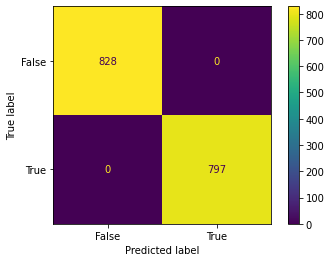

In [264]:
cm_display.plot()
plt.show()

In [265]:
# 6. Create a visualization of the decision tree.
text_representation = tree.export_text(dtc)
print(text_representation)

|--- feature_27 <= 0.50
|   |--- feature_53 <= 0.50
|   |   |--- feature_55 <= 0.50
|   |   |   |--- feature_101 <= 0.50
|   |   |   |   |--- feature_25 <= 0.50
|   |   |   |   |   |--- feature_22 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_22 >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_25 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_101 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- feature_55 >  0.50
|   |   |   |--- class: 0
|   |--- feature_53 >  0.50
|   |   |--- feature_21 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_21 >  0.50
|   |   |   |--- class: 0
|--- feature_27 >  0.50
|   |--- feature_100 <= 0.50
|   |   |--- feature_63 <= 0.50
|   |   |   |--- feature_7 <= 0.50
|   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |--- feature_36 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_36 >  0.50
|   |   |   |   |   |   |--- feature_20 <= 0.50

In [266]:
# 7. Use a χ2-statistic selector to pick the five best features for this data 
selector = SelectKBest(chi2, k=5)
selector.fit(m_xtrain, m_ytrain)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
top_features = mushrooms2.iloc[:,cols_idxs]

In [267]:
# 8. Which five features were selected in step 7? Hint: Use the get_support function.
top_features.columns

Index(['odor_c', 'odor_m', 'gill-size_n', 'stalk-surface-above-ring_f',
       'stalk-surface-below-ring_f'],
      dtype='object')

In [268]:
# 9. Repeat steps 4 and 5 with the five best features selected in step 7.
X2 = top_features
Y2 = mushrooms2['class']

In [269]:
# splitting data
m_xtrain2, m_xtest2, m_ytrain2, m_ytest2 = train_test_split(X2, Y2, test_size=0.2)

In [270]:
# dtc
dtc2 = DecisionTreeClassifier(random_state = 1234)
dtc_model2 = dtc2.fit(m_xtrain2, m_ytrain2)

In [271]:
# reporting results
dtcpredictions2 = dtc_model2.predict(m_xtest2)
print(classification_report(m_ytest2, dtcpredictions2))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81       842
           1       0.91      0.59      0.72       783

    accuracy                           0.77      1625
   macro avg       0.81      0.77      0.76      1625
weighted avg       0.81      0.77      0.77      1625



In [272]:
# score
print('Accuracy:',dtc_model2.score(m_xtest2, m_ytest2))

Accuracy: 0.7741538461538462


In [273]:
# confusion matrix
conf_matrix2 = confusion_matrix(m_ytest2, dtcpredictions2)
conf_matrix2

array([[796,  46],
       [321, 462]], dtype=int64)

In [274]:
cm_display2 = ConfusionMatrixDisplay(confusion_matrix = conf_matrix2, display_labels = [False, True])

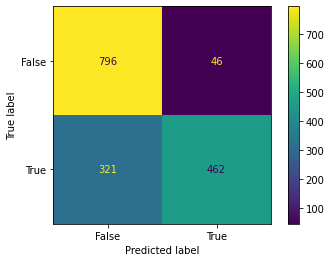

In [275]:
cm_display2.plot()
plt.show()

**10. Summarize your findings:** I found myself very surprised with the 100% accuracy of the model using all 118 dummy variable columns. I doubted myself heavily, running through multiple iterations of the model and setting variables to no avail. I did some research regarding this phenomenon and found that it could be because the model is overfitting the data due to the excess of parameters. When I used SelectKBest to use the 5 features with the best chi-squared values, I found the accuracy to be much more realistic, at around 78%. I think the lesson here is that feature selection is important because if not used, it could lead to overfitting and accuracies that appear succesful but are not. As opposed to part 1, where the feature selection seemed to bring the R2 score down and the errors up. Although it was using different feature selection for predicting values rather than classifying them. 